In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 8, 5
COLORS = ['r', 'g', 'b', 'c', 'm', 'y', 'purple', 'lime', 'pink', 'yellow', 'orange', 'brown']

from scipy.stats import multivariate_normal

In [2]:
def plot(data, ax, title):

    for i in range(len(data)):
        ax.scatter(data[i][0], data[i][1], color=COLORS[i], alpha=0.5, label=f"Class {i}")
        ax.set_title(title)
    ax.legend()


def load_data(directory, num_classes, delimiter=','):
    data = []
    for i in range(1, num_classes + 1):
        d = pd.read_csv(f'{directory}/Class{i}.txt', header=None, delimiter=delimiter)
        data.append(d)
        d['class'] = i - 1
    
    data.append(pd.concat(data).reset_index(drop=True))
    return tuple(data)

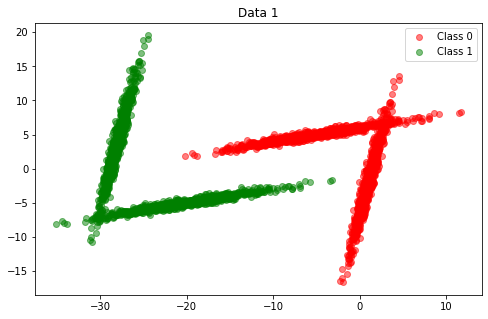

In [3]:
d1_c1, d1_c2, d1 = load_data('data_1', 2)

fig, ax = plt.subplots(1, 1, figsize=(8,5))
plot((d1_c1, d1_c2), ax, "Data 1")

In [4]:
from sklearn.model_selection import train_test_split

def split_data(data):
    X = data.drop('class', axis = 1)
    y = data['class']
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
    x_train.reset_index(drop=True, inplace=True)
    x_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    x_train = x_train.to_numpy()
    x_test = x_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()
    
    
    return (x_train, x_test, y_train, y_test)

d1_x_train, d1_x_test, d1_y_train, d1_y_test = split_data(d1)

In [5]:
class GMM:
    '''
    Gaussian Mixture Model based unsupervised clustering of the dataset.
    '''
    def __init__(self, n_components=1, tol=1e-3, max_iter=100, reg_covar=1e-6, random_state=42):
        # Number of gaussians.
        assert(n_components > 0)
        self.n_components = n_components
        # Tolerance to stop the iterations.
        self.tol = tol
        # Maximum number of iterations.
        assert(max_iter > 0)
        self.max_iter = max_iter
        # Current iteration while training GMM.
        self.curr_iter = 0
        # Non-negative regularization added to the diagonal of covariance.
        # It ensures that the covariance matrices are positive.
        assert(reg_covar >= 0)
        self.reg_covar = reg_covar
        self.reg_cov = None  # Shape = self.n_dims x self.n_dims
        
        # Number of dimensions in the dataset.
        self.n_dims = None
        # Number of points in the dataset.
        self.n = None
        
        # Parameters of GMM.
        self.mean = None  # Shape = self.n_components x self.n_dims
        self.cov = None   # Shape = self.n_components x self.n_dims x self.n_dims
        self.pi = None    # Shape = self.n_components
        
        # Latent variable. It is the responsibilities array.
        # It is the probability of a point belonging to each gaussian component.
        self.resp = None  # Shape = self.n x self.n_components
        
        # List of log likelihoods for each iteration.
        self.lls = []
        
        self.sorted_X = None
        self.XY = None
        
        # Set the random state for consistent results.
        np.random.seed(random_state)
        
    def init_params(self, X):
        '''Initialize parameters for the EM algorithm.'''
        # Initializing pi with 1 / self.n_components.
        self.pi = np.ones(self.n_components) / self.n_components
        
        # Initializing mean with random points from the dataset.
        indices = np.random.choice(X.shape[0], self.n_components)
        self.mean = np.float32(X[indices])
        
        # Initializing cov matrices with identity matrices.
        self.cov = np.empty((self.n_components, self.n_dims, self.n_dims))
        for k in range(self.n_components):
            self.cov[k] = np.identity(self.n_dims)
            
        # Initializing self.reg_cov.
        self.reg_cov = self.reg_covar * np.identity(self.n_dims)
        
        # Creating empty array for storing the responsibilities.
        self.resp = np.empty((self.n, self.n_components))
        
        # Initialize data for plotting gaussians later.
        self.sorted_X = [np.sort(X[:, 0]), np.sort(X[:, 1])]
        x, y = np.meshgrid(self.sorted_X[0], self.sorted_X[1])
        self.XY = np.array([x.flatten(), y.flatten()]).T
    
    def e_step(self, X):
        '''Expectation step of the EM algorithm.'''
        denominator = np.zeros(self.n)
        for k in range(self.n_components):
            dist = multivariate_normal(mean=self.mean[k], cov=self.cov[k] + self.reg_cov)
            denominator += self.pi[k] * dist.pdf(X)

        for k in range(self.n_components):
            dist = multivariate_normal(mean=self.mean[k], cov=self.cov[k] + self.reg_cov)

            numerator = self.pi[k] * dist.pdf(X)
            self.resp[:, k] = numerator / denominator
            
    def m_step(self, X):
        '''Maximization step of the EM algorithm.'''
        # Sum of responsibilities for each gaussian component.
        nk = self.resp.sum(axis=0)  # Shape = self.n_components
        
        self.pi = nk / np.sum(nk)
        self.mean = np.dot(self.resp.T, X) / nk[:, np.newaxis]
        
        for k in range(self.n_components):
            diff = X - self.mean[k]
            self.cov[k] = np.dot(self.resp[:, k] * diff.T, diff) / nk[k]
            

            
    def log_likelihood(self, X):
        return np.log(self.likelihood(X))
    
    def likelihood(self, X):
        l = 0
        for k in range(self.n_components):
            dist = multivariate_normal(mean=self.mean[k], cov=self.cov[k])
            l += np.sum(self.pi[k] * dist.pdf(X))
        
        return l
    
    
    def fit(self, X):
        '''Fit gaussians on the input dataset.'''
        self.n, self.n_dims = X.shape
        
        # Initialize the parameters.
        self.init_params(X)
        self.plot_gaussians(X)
        
        # Calculating initial log likelihood value.
        llOld = float("-inf")
        ll = self.log_likelihood(X)
        self.lls.append(ll)
        
        while (self.curr_iter < self.max_iter and (ll - llOld > self.tol)):
            # Expectation step.
            self.e_step(X)

            # Maximization step.
            self.m_step(X)
            
            llOld = ll
            ll = self.log_likelihood(X)
            # Caching log likelihood value to plot the graph after training.
            self.lls.append(ll)
            
            self.curr_iter += 1
            
            # Plotting the gaussian components.
            if self.curr_iter % 10 == 0:
                self.plot_gaussians(X, title=f"Gaussian components after {self.curr_iter} iterations.")
        
        self.plot_lls()
        
    def plot_lls(self):
        '''Line plot of Log Likelihood for each iteration.'''
        fig, ax = plt.subplots(1, 1, figsize=(8,5))
        ax.plot(np.arange(self.curr_iter + 1), self.lls)
#         ax.plot(np.arange(self.curr_iter), self.lls)
        ax.set_title("Log Likelihood")
        
    def plot_gaussians(self, X, title="Initial Gaussian Components."):
        '''Plot the gaussian components.'''
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.scatter(X[:, 0], X[:, 1])
        
        for mu, sigma in zip(self.mean, self.cov):
            dist = multivariate_normal(mu, sigma + self.reg_cov)
            ax.contour(self.sorted_X[0], self.sorted_X[1],
                       dist.pdf(self.XY).reshape(self.n, self.n),
                       colors='black', alpha=0.3)
            ax.scatter(mu[0], mu[1], c='grey', zorder=10, s=100)
            ax.set_title(title)
        plt.show()
        

In [6]:
class GMMClassifier:
    '''
    A bayes classifier which assumes the input to be from a multimodal
    gaussian distribution.
    '''
    def __init__(self, n_components=1, tol=1e-3, max_iter=100, reg_covar=1e-6, random_state=42):
        # Number of gaussians.
        assert(n_components > 0)
        self.n_components = n_components
        # Tolerance to stop the iterations.
        self.tol = tol
        # Maximum number of iterations.
        assert(max_iter > 0)
        self.max_iter = max_iter
        # Non-negative regularization added to the diagonal of covariance.
        # It ensures that the covariance matrices are positive.
        assert(reg_covar >= 0)
        self.reg_covar = reg_covar
        # Random state to obtain consistent results.
        self.random_state = random_state
        
        # Number of dimensions in the dataset.
        self.n_dims = None
        # Number of points in the dataset.
        self.n = None
        # Number of classes in the dataset.
        self.n_classes = None
        # Actual classes in the dataset.
        self.classes = None
        # Frequency count of each class in the dataset.
        self.class_counts = None
        
        # Dictionary of GMMs for each class in the dataset.
        self.gmm = dict()
        # Prior probabilities for each class.
        self.prior = None

    
    def fit(self, X, y):
        self.n, self.n_dims = X.shape
        
        self.classes, self.class_counts = np.unique(y, return_counts=True)
        self.n_classes = self.classes.shape[0]
        
        self.prior = {self.classes[i]: self.class_counts[i] / self.n for i in range(self.n_classes)}
        
        # Segregating the training data based on classes and fitting GMM on each of them.
        for cls in self.classes:
            X_cls = X[y == cls]
            mixture = GMM(self.n_components, self.tol, self.max_iter, self.reg_covar, self.random_state)
            mixture.fit(X_cls)
            self.gmm[cls] = mixture


    def predict(self, X):
        pred = np.empty(X.shape[0])
        
        for i in range(X.shape[0]):
            x = X[i]
            
            mx_posterior = -1
            mx_cls = -1
            for cls in self.classes:
                posterior = self.gmm[cls].likelihood(x) * self.prior[cls]
                
                if (posterior > mx_posterior):
                    mx_posterior = posterior
                    mx_cls = cls
            
            pred[i] = mx_cls

        return pred

In [7]:
from sklearn.metrics import confusion_matrix

def fit_gmm(x_train, y_train, n_components=1, tol=1e-3, max_iter=100, reg_covar=1e-6, random_state=42):
    gmm = GMMClassifier(n_components, tol, max_iter, reg_covar, random_state)
    gmm.fit(x_train, y_train)
    
    return gmm

def predict(model, x_test, y_test):
    y_pred = model.predict(x_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    
    return (y_pred, conf_mat)

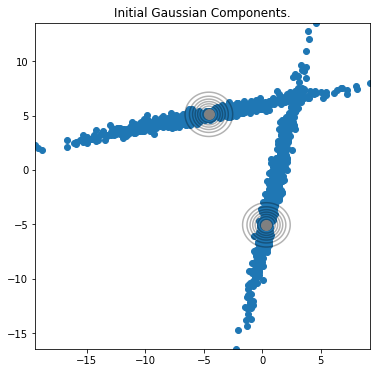

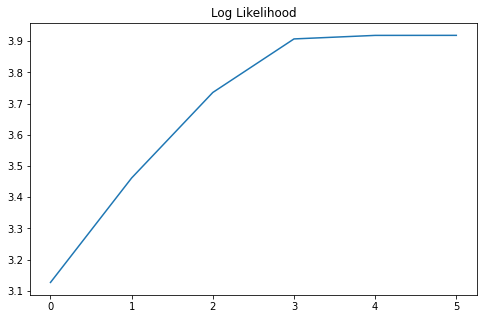

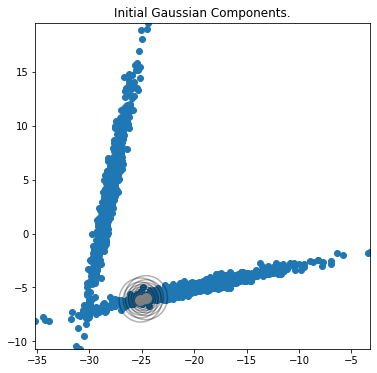

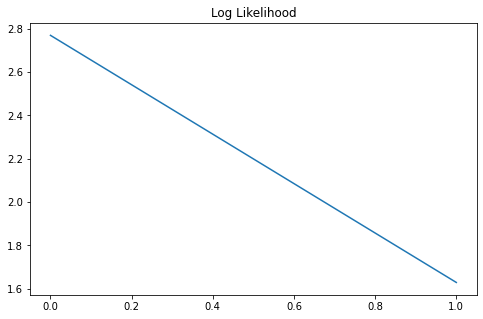

In [8]:
gmm = fit_gmm(d1_x_train, d1_y_train, n_components=2, max_iter=20)

In [9]:
pred, conf = predict(gmm, d1_x_test, d1_y_test)
conf

array([[421,   1],
       [  0, 378]])

In [10]:
def plot_test(data, ax, title):

    for i in range(len(data)):
        ax.scatter(data[i][:, 0], data[i][:, 1], color=COLORS[i], alpha=0.5, label=f"Class {i}")
        ax.set_title(title)
    ax.legend()

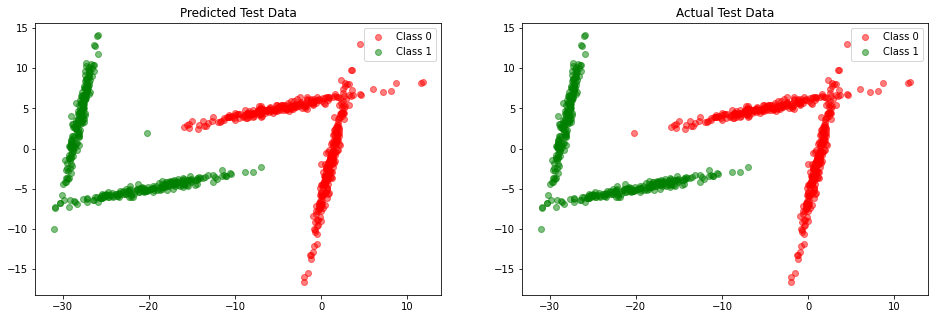

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
plot_test((d1_x_test[pred == 0], d1_x_test[pred == 1]), ax[0], "Predicted Test Data")
plot_test((d1_x_test[d1_y_test == 0], d1_x_test[d1_y_test == 1]), ax[1], "Actual Test Data")

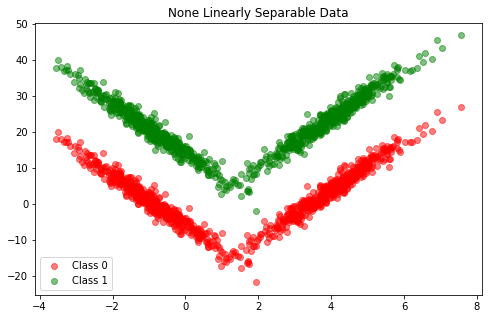

In [12]:
nls_c1, nls_c2, nls = load_data('nls_data', 2)

fig, ax = plt.subplots(1, 1, figsize=(8,5))
plot((nls_c1, nls_c2), ax, "None Linearly Separable Data")

In [13]:
nls_x_train, nls_x_test, nls_y_train, nls_y_test = split_data(nls)

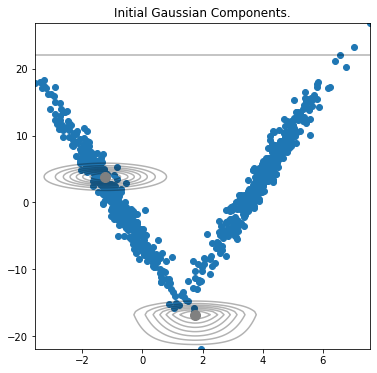

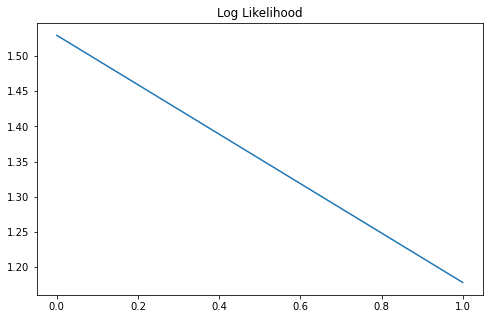

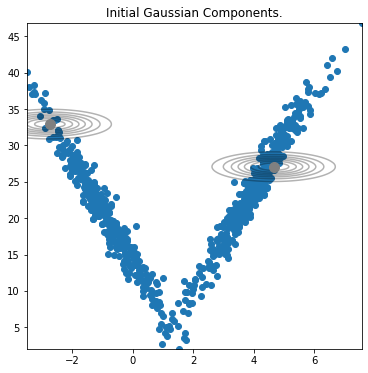

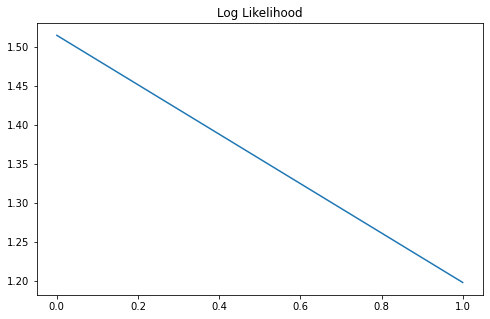

In [14]:
gmm = fit_gmm(nls_x_train, nls_y_train, n_components=2, max_iter=20)

In [15]:
pred, conf = predict(gmm, nls_x_test, nls_y_test)
conf

array([[183,  16],
       [ 12, 189]])

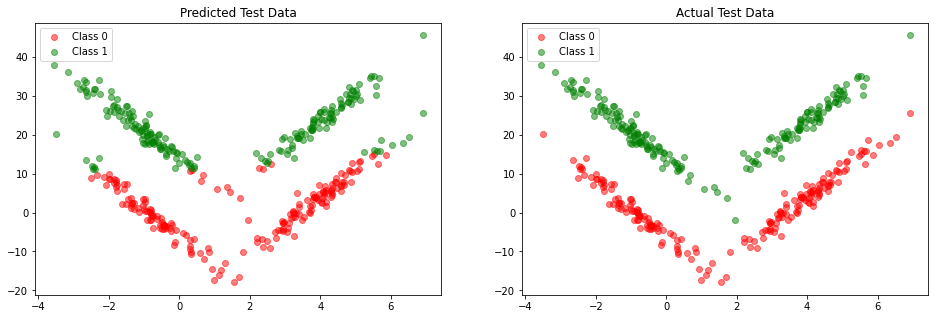

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
plot_test((nls_x_test[pred == 0], nls_x_test[pred == 1]), ax[0], "Predicted Test Data")
plot_test((nls_x_test[nls_y_test == 0], nls_x_test[nls_y_test == 1]), ax[1], "Actual Test Data")

In [17]:
class KMeansClassifier:
    def __init__(self, n_clusters=8, max_iter=300, viz=False):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.curr_iter = 0
        self.cluster_centers = None
        self.viz = viz
        self.cluster_to_class = dict()
        
    def fit(self, X, Y):
        # Choosing random points as cluster centers.
        indices = np.random.choice(X.shape[0], self.n_clusters)
        self.cluster_centers = np.float32(X[indices])

        cluster_assignments = self.assign_clusters(X)
        self.show_clusters(X, cluster_assignments) if self.viz else None
        
        while self.curr_iter < self.max_iter:
            self.curr_iter += 1
            # Update cluster centers using the mean of cluster points.
            self.update_centers(X, cluster_assignments)

            # Assigning new clusters based on the updated cluster centers.
            new_assignments = self.assign_clusters(X)
            
            # If no change, then break.
            flag = np.all(new_assignments == cluster_assignments)
            if (flag):
                break
            
            # Update the cluster assignments.
            cluster_assignments = new_assignments
            self.show_clusters(X, cluster_assignments) if self.viz else None
            
        self.map_cluster_to_class(cluster_assignments, Y)
        
    def predict(self, X):
        cluster_assignments = self.assign_clusters(X)
        predictions = np.empty(X.shape[0])
        
        for i in range(X.shape[0]):
            predictions[i] = self.cluster_to_class[cluster_assignments[i]]
        return predictions
            
    def update_centers(self, X, cluster_assignments):
        for i in range(self.n_clusters):
            self.cluster_centers[i] = np.mean(X[cluster_assignments == i], axis=0)   
            
    def show_clusters(self, X, cluster_assignments):
        fig, ax = plt.subplots(1, 1)
        for i in range(self.n_clusters):
            ax.scatter(X[cluster_assignments == i, 0],
                        X[cluster_assignments == i, 1],
                        color=COLORS[i],
                        alpha=0.5)

            ax.scatter(self.cluster_centers[i][0],
                        self.cluster_centers[i][1],
                        color=COLORS[i],
                        s=300,
                        edgecolors='k')
        ax.set_title(f"Clusters after {self.curr_iter} iterations.")
        #plt.axis('equal')
        plt.show()
        
    def assign_clusters(self, X):
        cluster_assignments = None
        
        min_dist = np.array([float('inf')] * X.shape[0])
        for i in range(self.n_clusters):
            # Distance of each point from the ith cluster center.
            dist = np.sqrt(np.sum((X - self.cluster_centers[i])**2, axis=1))
            
            # Assigning ith cluster to the points where distance is lesser
            # than the previous assignment.
            cluster_assignments = np.where(dist < min_dist, i, cluster_assignments)
            
            # Updating the minimum distance for points.
            min_dist = np.where(dist < min_dist, dist, min_dist)
     
        return cluster_assignments
    
    def map_cluster_to_class(self, class_assignments, Y):
        for i in range(self.n_clusters):
            counts = np.bincount(Y[class_assignments == i])
            self.cluster_to_class[i] = np.argmax(counts)


In [18]:
def fit_kmeans(x_train, y_train, n_clusters=8, max_iter=300, viz=False):
    kmeans = KMeansClassifier(n_clusters, max_iter, viz)
    kmeans.fit(x_train, y_train)
    
    return kmeans

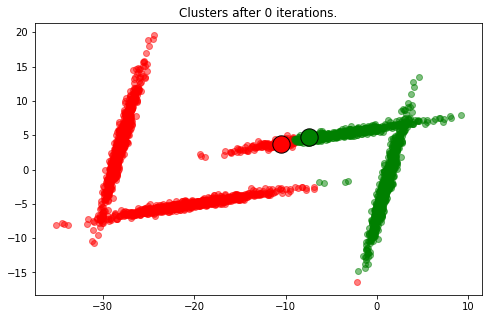

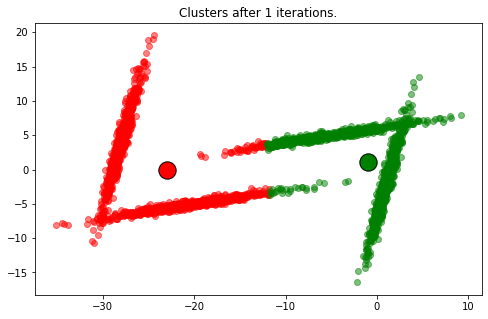

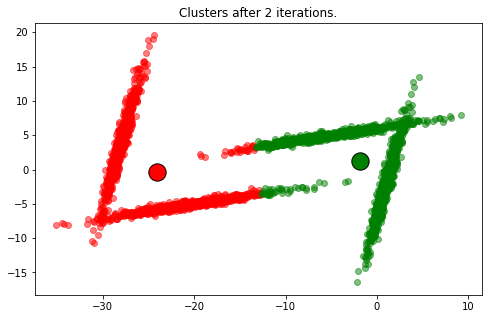

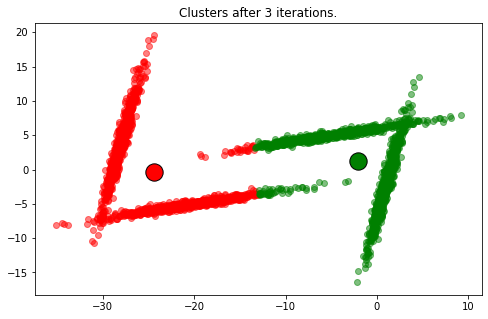

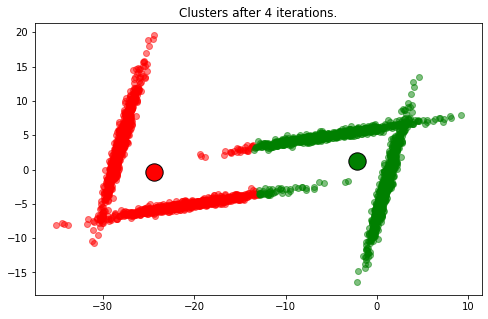

In [19]:
kmeans = fit_kmeans(d1_x_train, d1_y_train, 2, viz=True)

In [20]:
pred, conf = predict(kmeans, d1_x_test, d1_y_test)
conf

array([[412,  10],
       [ 14, 364]])